# Evolution of a salesman: A complete genetic algorithm tutorial for Python

- Modified version of *Evolution of a salesman: A complete genetic algorithm tutorial for Python*,  Eric Stoltz, 2018. Source: https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
- Original Jupyter Notebook: https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb

### I strongly suggest to you read and study the original article and code (above). There are only comments to modified parts.


In [1]:
%matplotlib notebook
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, matplotlib.patches as patches, seaborn
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation

In [31]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    # Import to covnert to list.
    def list_out(self):
        return (self.x, self.y)
    
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness
    
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)   
    
    
# For avoid numeric errors with sucessives invertions.
def rankRoutesDistance(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeDistance()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1))   
  
def selection(popRanked,deathSize):
    selectionResults = []
    for i in range(0, len(popRanked)-deathSize):
        selectionResults.append(popRanked[i][0])
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool



def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child


# To make random pairs, keep pop size and elite group,
# discarding non-elite parents, keeping only children 
# (with elite group). Yes! This is hard different from
# original. basically, the worst ones die, keep the best
# ones for breeding. Only the elite group and the 
# children survive. 
def breedPopulation(matingpool, eliteSize, deathSize):
    children = []
    length = len(matingpool)+deathSize
    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length-eliteSize):
        parent = random.sample(matingpool, 2)   
        child = breed(parent[0], parent[1])
        children.append(child)
    return children



def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual


def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop


def order_pop_rank(population, popRanked):
    selectionResults = []
    for i in range(0, len(popRanked)):
        selectionResults.append(popRanked[i][0])
    pop_out = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        pop_out.append(population[index])
    return pop_out



# To plot the path for any given pop (best_pop_ever=pop)
def plot_path(best_pop_ever,title='Path'):
    path = []
    codes = []
    codes.append(Path.MOVETO)

    max_x = 0
    max_y = 0

    for i in range(len(best_pop_ever[0])):
        path.append(best_pop_ever[0][i].list_out())
        max_x = max(max_x,best_pop_ever[0][i].x)
        max_y = max(max_y,best_pop_ever[0][i].y)

    path.append(best_pop_ever[0][0].list_out())

    for i in range(len(best_pop_ever[0])-1):
        codes.append(Path.LINETO)

    codes.append(Path.CLOSEPOLY)

    path_Path = Path(path, codes)
    patch = patches.PathPatch(path_Path, lw=2, facecolor='w', alpha=0.5)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.clear()
    ax.add_patch(patch)
    ax.set_xlim(-10, max_x+10)
    ax.set_ylim(-10, max_y+10)
    x, y = zip(*path_Path.vertices)
    line, = ax.plot(x, y, 'o-')
    plt.title(title)

    fig.canvas.draw()

# Generate a new city group.

In [3]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))


# To keep the best path ever.
best_distance_ever = np.float('Inf')
best_pop_ever = None

<IPython.core.display.Javascript object>


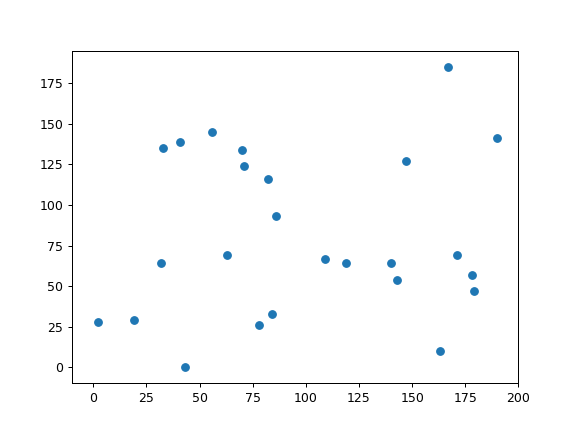

In [4]:
path_x = []
path_y = []

max_x = 0
max_y = 0

for i in range(len(cityList)):
    path_x.append(cityList[i].x)
    path_y.append(cityList[i].y)
    max_x = max(max_x,path_x[-1])
    max_y = max(max_y,path_y[-1])
    
plt.figure()
plt.xlim(-10, max_x+10)
plt.ylim(-10, max_y+10)

plt.scatter(path_x,path_y)
plt.show()

# Run the algorithm

## This part you can run many times. Running only the cell below, it will preserve the best solution ever and keep the original cities.

<IPython.core.display.Javascript object>


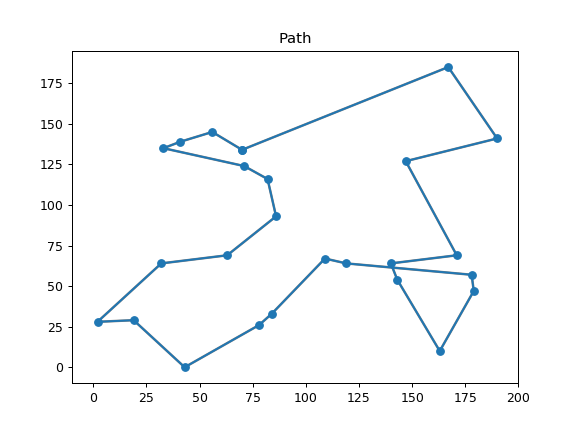

In [50]:
popSize=100
eliteSize=10
# How many must die!
deathSize=20
mutationRate=0.002
generations=1000

progress = []
progress_best = []
pop = initialPopulation(popSize, cityList)
pop = order_pop_rank(pop, rankRoutes(pop))
best_distance = rankRoutesDistance(pop)[0][1]
progress.append(best_distance)
progress_best.append(best_distance)

currentGen = pop
currentGen_best = pop

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(generations):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, deathSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, deathSize)
    nextGeneration = mutatePopulation(children, mutationRate) 
    currentGen = nextGeneration
    pop = order_pop_rank(currentGen, rankRoutes(currentGen))
    best_distance_now = rankRoutesDistance(pop)[0][1]
    progress.append(best_distance_now)
    
    # the fallow lines is to plot the path for each iteration.
    
    if best_distance_now<best_distance:
        best_distance = best_distance_now
        currentGen_best = order_pop_rank(pop,rankRoutes(pop))
    progress_best.append(best_distance)
    
    path = []
    codes = []
    codes.append(Path.MOVETO)

    max_x = 0
    max_y = 0

    currentGen_best = order_pop_rank(currentGen_best,rankRoutes(currentGen_best))
    for i in range(len(currentGen_best[0])):
        path.append(currentGen_best[0][i].list_out())
        max_x = max(max_x,currentGen_best[0][i].x)
        max_y = max(max_y,currentGen_best[0][i].y)

    path.append(currentGen_best[0][0].list_out())

    for i in range(len(currentGen_best[0])-1):
        codes.append(Path.LINETO)

    codes.append(Path.CLOSEPOLY)

    path_Path = Path(path, codes)
    patch = patches.PathPatch(path_Path, lw=2, facecolor='w', alpha=0.5)

    ax.clear()
    ax.add_patch(patch)
    ax.set_xlim(-10, max_x+10)
    ax.set_ylim(-10, max_y+10)
    x, y = zip(*path_Path.vertices)
    line, = ax.plot(x, y, 'o-')
    plt.title('Path')

    fig.canvas.draw()
    
# Save the actual best if it is the best ever.
if best_distance < best_distance_ever:
    best_distance_ever = best_distance
    best_pop_ever = currentGen_best


Best distance: 854.70
Best distance ever: 800.12


<IPython.core.display.Javascript object>


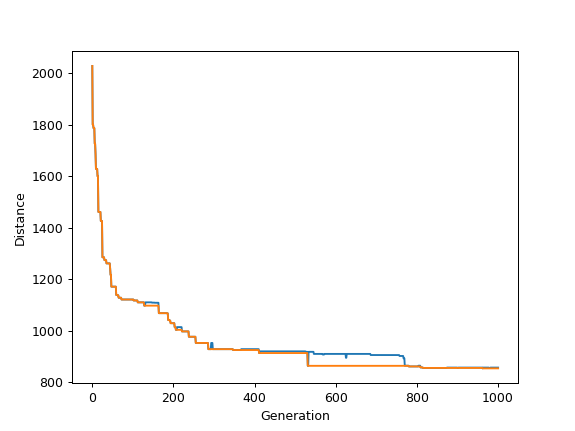

In [51]:
print('Best distance: {:.2f}'.format(best_distance))
print('Best distance ever: {:.2f}'.format(best_distance_ever))
plt.close()
plt.figure(2)
plt.plot(progress)
plt.plot(progress_best)
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.show()

<IPython.core.display.Javascript object>


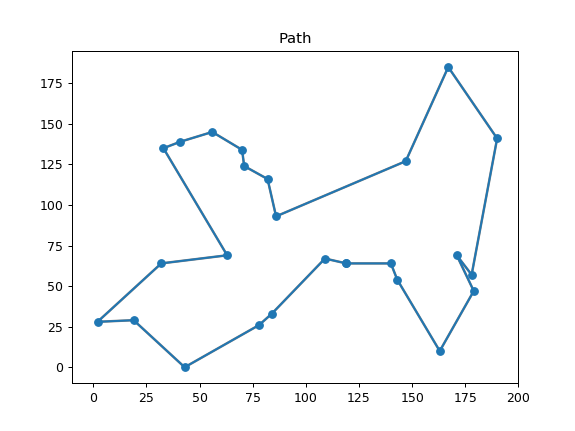

In [52]:
plot_path(best_pop_ever)